In [1]:
# Install required libraries
!pip install tensorflow kaggle

# Download the dataset (you'll need to upload your kaggle.json file first)
# Upload your kaggle.json file using the file upload button in Colab
from google.colab import files
files.upload()  # Upload your kaggle.json file

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# Unzip the dataset
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.79GB/s]


In [2]:
import os
import shutil
import random
from pathlib import Path

# Create validation directory structure
os.makedirs('validation/REAL', exist_ok=True)
os.makedirs('validation/FAKE', exist_ok=True)

# Set seed for reproducibility
random.seed(42)

# Move 10,000 REAL images from train to validation
real_train_path = 'train/REAL'
real_val_path = 'validation/REAL'
real_images = os.listdir(real_train_path)
random.shuffle(real_images)
images_to_move = real_images[:10000]

for img in images_to_move:
    src = os.path.join(real_train_path, img)
    dst = os.path.join(real_val_path, img)
    shutil.move(src, dst)

print(f"Moved {len(images_to_move)} REAL images to validation")

# Move 10,000 FAKE images from train to validation
fake_train_path = 'train/FAKE'
fake_val_path = 'validation/FAKE'
fake_images = os.listdir(fake_train_path)
random.shuffle(fake_images)
images_to_move = fake_images[:10000]

for img in images_to_move:
    src = os.path.join(fake_train_path, img)
    dst = os.path.join(fake_val_path, img)
    shutil.move(src, dst)

print(f"Moved {len(images_to_move)} FAKE images to validation")

# Verify the split
print(f"\nTrain REAL images: {len(os.listdir('train/REAL'))}")
print(f"Train FAKE images: {len(os.listdir('train/FAKE'))}")
print(f"Validation REAL images: {len(os.listdir('validation/REAL'))}")
print(f"Validation FAKE images: {len(os.listdir('validation/FAKE'))}")
print(f"Test REAL images: {len(os.listdir('test/REAL'))}")
print(f"Test FAKE images: {len(os.listdir('test/FAKE'))}")

Moved 10000 REAL images to validation
Moved 10000 FAKE images to validation

Train REAL images: 40000
Train FAKE images: 40000
Validation REAL images: 10000
Validation FAKE images: 10000
Test REAL images: 10000
Test FAKE images: 10000


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
# Load datasets using image_dataset_from_directory
img_height = 32
img_width = 32
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    'train',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 80000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [4]:
# Build CNN model based on the paper architecture (Figure 5)
def build_cifake_model():
    model = keras.Sequential([
        # Rescaling layer
        layers.Rescaling(1./255, input_shape=(32, 32, 3)),

        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Third Conv Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create the model
model = build_cifake_model()

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,409 (2.10 MB)

 Trainable params: 549,409 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Setup ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint]
)

Epoch 1/30
2492/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8170 - loss: 0.3847
Epoch 1: val_loss improved from inf to 0.22304, saving model to best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.8172 - loss: 0.3844 - val_accuracy: 0.9118 - val_loss: 0.2230
Epoch 2/30
2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9118 - loss: 0.2226
Epoch 2: val_loss improved from 0.22304 to 0.18521, saving model to best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9118 - loss: 0.2226 - val_accuracy: 0.9286 - val_loss: 0.1852
Epoch 3/30
2490/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9254 - loss: 0.1889
Epoch 3: val_loss improved from 0.18521 to 0.16445, saving model to best_model.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9254 - loss: 0.1889 - val_accuracy: 0.9373 - val_loss: 0.1644
Epoch 4/30
2495/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9307 - loss: 0.1769
Epoch 4: val_loss did not improve fro

In [6]:
# Load the best model
best_model = keras.models.load_model('best_model.keras')

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f'\nTest accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss:.4f}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9456 - loss: 0.1311

Test accuracy: 94.69%
Test loss: 0.1342


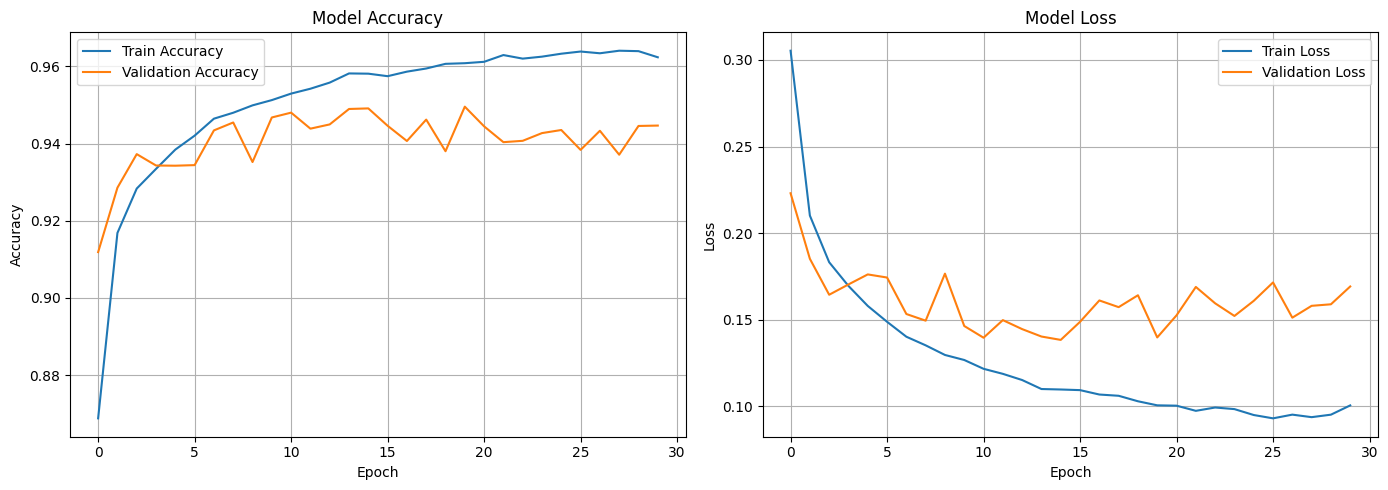


Final Training Accuracy: 96.24%
Final Validation Accuracy: 94.46%
Final Test Accuracy: 94.69%


In [7]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f'\nFinal Training Accuracy: {history.history["accuracy"][-1] * 100:.2f}%')
print(f'Final Validation Accuracy: {history.history["val_accuracy"][-1] * 100:.2f}%')
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')